# **Flower Recognition With Pytroch**
## **Building simple CNN**

Goal of this notebook is showcasing how to build a custom CNN and train it on a relatively small dataset. The trained model will serve as a benchmark for later training with more complex models.






## 0. Importing libraries and dataset


In [209]:
import kagglehub
path = kagglehub.dataset_download("alxmamaev/flowers-recognition")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/flowers-recognition


Description form kaggle:

> This dataset contains 4242 images of flowers.
The data collection is based on the data flicr, google images, yandex images.
You can use this datastet to recognize plants from the photo.
The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion.
For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!



In [184]:
import numpy as np
import pandas as pd
import torch
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from PIL import Image, UnidentifiedImageError
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary


import warnings
warnings.filterwarnings('ignore')

## 1. Analysing dataset

In [185]:
# Reading data into Dataframe
root_dir = path + '/flowers'

def make_csv(path):
    image_data = []
    for d in os.listdir(path):
        for f in os.listdir(f'{root_dir}/{d}'):
            image_path = os.path.join(root_dir,d, f)
            image_data.append({
                    'image_name': f,
                    'species': d,
                    'full_path': image_path
                    })
    return pd.DataFrame(image_data)

In [186]:
df = make_csv(root_dir)
df.head(5)

image_name    species  \
0  34578947551_863af3acb3_n.jpg  dandelion   
1     2625836599_03e192266f.jpg  dandelion   
2    16242239484_51286673af.jpg  dandelion   
3   5716633491_55e6f02645_n.jpg  dandelion   
4  34697163155_5dc2571f23_n.jpg  dandelion   

                                           full_path  
0  /kaggle/input/flowers-recognition/flowers/dand...  
1  /kaggle/input/flowers-recognition/flowers/dand...  
2  /kaggle/input/flowers-recognition/flowers/dand...  
3  /kaggle/input/flowers-recognition/flowers/dand...  
4  /kaggle/input/flowers-recognition/flowers/dand...

In [187]:
def print_info():
    '''Function to print info about dataset '''
    corrupt_images = []
    sizes = []
    color_modes = Counter()

    for path in df['full_path']:
        try:
            with Image.open(path) as img:
                sizes.append(img.size)  # (width, height)
                color_modes[img.mode] += 1
        except UnidentifiedImageError:
            corrupt_images.append(path)

    total_images = df.shape[0]
    unique_species = ', '.join(df['species'].unique())
    size_array = np.array(sizes)
    avg_size = np.mean(size_array, axis=0)
    dist = df['species'].value_counts()
    # Temporarily add extension column for counting
    extensions = df['image_name'].str.extract(r'\.([a-zA-Z0-9]+)$')
    ext_counts = extensions[0].value_counts()

    print("\n=== Dataset Summary === \n")
    print(f"Total images: {total_images}")
    print(f"Species found: {unique_species}")
    print(f"Corrupted images: {len(corrupt_images)}")
    print("Class distribution:")
    for species, count in dist.items():
        print(f"  {species:<15} : {count}")

    print("\nImage format counts:")
    for ext, count in ext_counts.items():
        print(f"  .{ext}: {count}")

    print("\nImage color modes:")
    for mode, count in color_modes.items():
        print(f"  {mode}: {count}")

    print(f"\nAverage image size (width x height): {avg_size[0]:.1f} x {avg_size[1]:.1f} pixels\n")

    if corrupt_images:
        print("List of corrupted images:")
        for img_path in corrupt_images:
            print(f"  {img_path}")


In [188]:
print_info()


=== Dataset Summary === 

Total images: 4317
Species found: dandelion, daisy, sunflower, tulip, rose
Corrupted images: 0
Class distribution:
  dandelion       : 1052
  tulip           : 984
  rose            : 784
  daisy           : 764
  sunflower       : 733

Image format counts:
  .jpg: 4317

Image color modes:
  RGB: 4317

Average image size (width x height): 338.4 x 253.1 pixels



The dataset contains 4,317 RGB images across 5 flower species (dandelion, daisy, sunflower, tulip, rose).
All images are in .jpg format, with an average resolution of 338×253 pixels.
There are no corrupted images, and the class distribution is fairly balanced, with each class containing between 733 and 1052 images.

In [189]:
# Plotting random samples

# Number of sample images to show
MIN_SAMPLE_SIZE = 50
SAMPLE_FRACTION = 0.05

# Calculate sample size based on DataFrame size (at least MIN_SAMPLE_SIZE)
sample_size = max(MIN_SAMPLE_SIZE, int(SAMPLE_FRACTION * df.shape[0]))

# Randomly sample sorted full image paths
sample_paths = random.sample(df['full_path'].sort_values().tolist(), sample_size)

def show_image_grid(image_paths, rows=4, cols=5):
    """
    Display a grid of images given a list of image file paths.

    Args:
        image_paths (list): List of image file paths to display.
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.
    """
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

    for i, ax in enumerate(axes.flat):
        if i < len(image_paths):
            try:
                with Image.open(image_paths[i]) as img:
                    ax.imshow(img)
                    # Show parent folder name as title for context
                    folder_name = os.path.basename(os.path.dirname(image_paths[i]))
                    ax.set_title(f"{folder_name}")
                    ax.axis('off')
            except Exception as e:
                # Hide axes for images that fail to load
                ax.set_visible(False)
                print(f"Warning: Could not open image {image_paths[i]} - {e}")
        else:
            # Hide any extra empty subplots
            ax.set_visible(False)

    plt.tight_layout()
    plt.show()

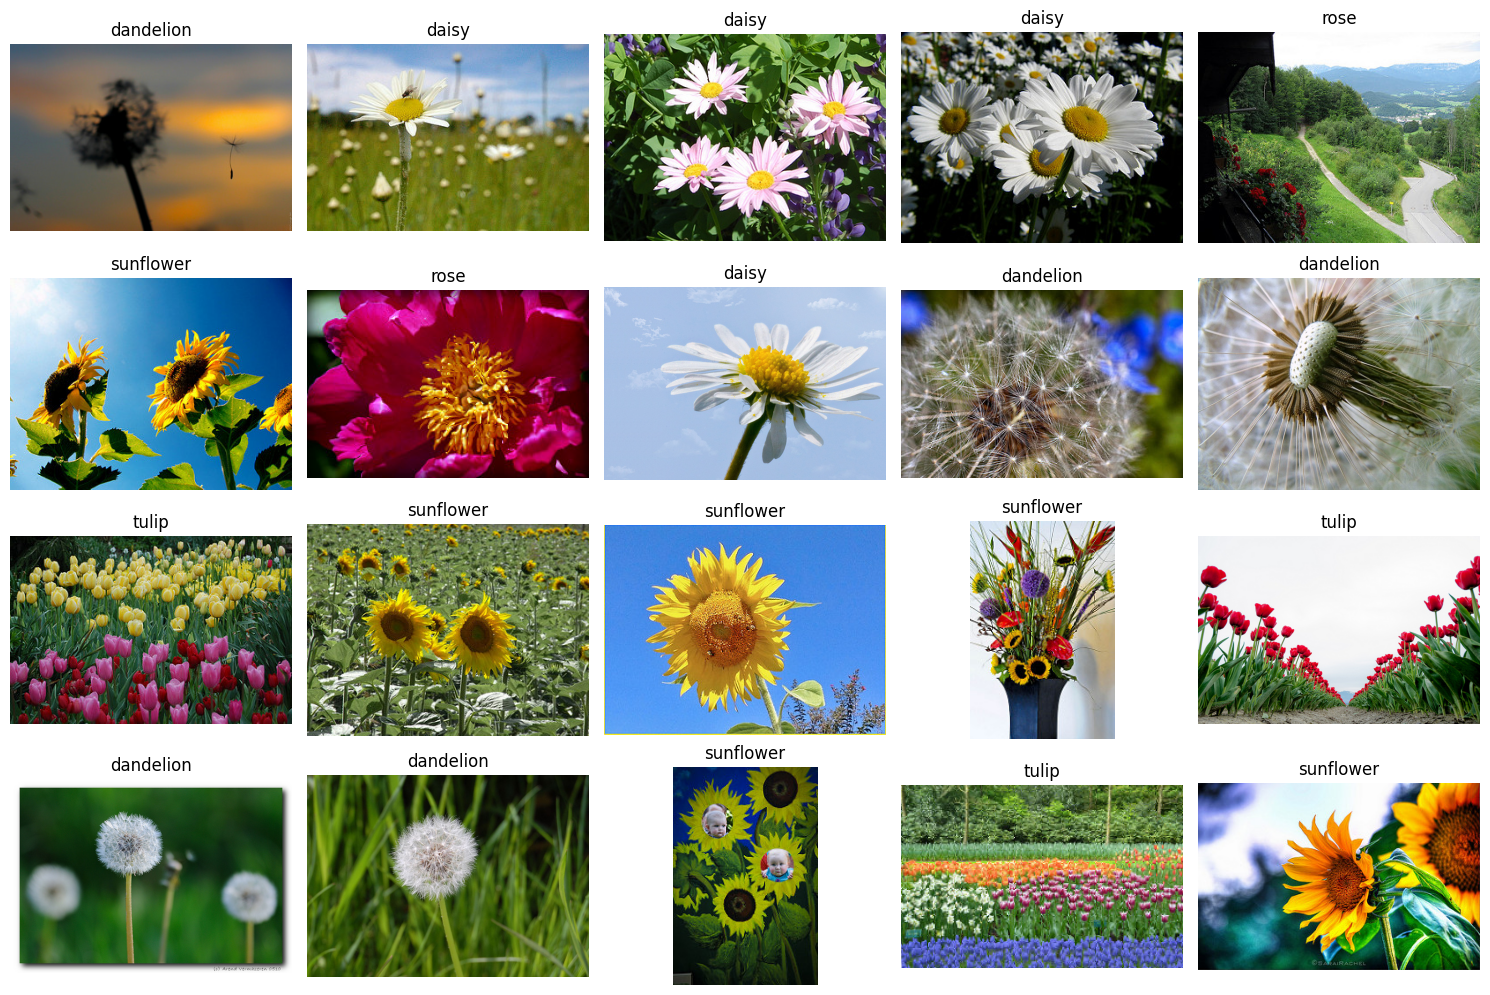

In [190]:
show_image_grid(sample_paths)

## 2. Prepering the data

### Normalisation
- The first preprocessing step is computing the dataset mean and standard deviation for normalization. Normalization stabilizes training,speeds Up convergence and leads to better generalization.
- **Pooling** is needed because mean and std must be computed over all pixels in the dataset, not averaged per image — otherwise images with fewer or more pixels (or very low variance) distort the result.
By summing values and squared values across the whole dataset first, pooling gives the true global distribution of pixel intensities per channel.

**Pooled Mean and Standard Deviation**
- We want to compute dataset-level statistics across **all pixels** (not just average per-image).

**Mean per channel:**

$$
\mu_c = \frac{1}{N} \sum_{i=1}^{N} x_{i,c}
$$

where  
- \(x_{i,c}\) is the value of pixel \(i\) in channel \(c\),  
- \(N\) is the total number of pixels in that channel (across all images).

**Variance per channel:**

$$
\sigma_c^2 = \frac{1}{N} \sum_{i=1}^{N} x_{i,c}^2 - \mu_c^2
$$

**Standard deviation per channel:**

$$
\sigma_c = \sqrt{\sigma_c^2}
$$


---

**Normalization Formula**
When normalizing an image tensor, each channel is transformed as:

$$
x_{i,c}^\text{norm} = \frac{x_{i,c} - \mu_c}{\sigma_c}
$$

where:
- $x_{i,c}$ = raw pixel value (scaled to $[0,1]$)  
- $\mu_c$, $\sigma_c$ = dataset mean and std for channel $c$  
- $x_{i,c}^{\text{norm}}$ = normalized pixel value (centered around 0 with unit variance)

In [191]:
def compute_train_mean_std(train_paths, resize=(224, 224)):
    # Pooled (channel-wise) mean/std over all pixels in all training images
    n_pixels = 0
    sum_c = np.zeros(3, dtype=np.float64)
    sumsq_c = np.zeros(3, dtype=np.float64)

    for p in train_paths:
        try:
            img = Image.open(p).convert('RGB')
            if resize is not None:
                img = img.resize(resize, Image.BILINEAR)
            x = np.asarray(img, dtype=np.float32) / 255.0  # H,W,3 in [0,1]
            x = x.reshape(-1, 3)                           # (H*W, 3)
            n = x.shape[0]
            sum_c   += x.sum(axis=0)
            sumsq_c += (x * x).sum(axis=0)
            n_pixels += n
        except Exception as e:
            print(f"Error reading {p}: {e}")
            continue

    mean = sum_c / n_pixels
    var  = (sumsq_c / n_pixels) - (mean ** 2)
    std  = np.sqrt(np.clip(var, 1e-12, None))
    return mean, std


### Next in line is encoding labels and spliting dataset  

In [192]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['species'])

# Features and encoded target
X = df.drop(['species', 'label'], axis=1)
y = df['label']



df_trainval, df_test = train_test_split(
    df,
    test_size=0.1,        # 10% test
    stratify=df['species'], # preserve label distribution
    random_state=42
)

# Then split train and validation (e.g., 10% val of remaining 90%)
df_train, df_val = train_test_split(
    df_trainval,
    test_size=0.1111,     # ~10% of original data (0.1111 * 0.9 ≈ 0.1)
    stratify=df_trainval['species'],
    random_state=42
)

# Check sizes:
print(f"Train size: {len(df_train)}")
print(f"Validation size: {len(df_val)}")
print(f"Test size: {len(df_test)}")

# Optional: add a 'split' column to the original dataframe for bookkeeping
df_train = df_train.copy()
df_val = df_val.copy()
df_test = df_test.copy()

df_train['split'] = 'train'
df_val['split'] = 'val'
df_test['split'] = 'test'

df_final = pd.concat([df_train, df_val, df_test]).reset_index(drop=True)

Train size: 3453
Validation size: 432
Test size: 432


In [193]:
mean, std = compute_train_mean_std(df_train['full_path'])
print("Dataset Mean (R, G, B):", mean)
print("Dataset Std (R, G, B):", std)

Dataset Mean (R, G, B): [0.45952954 0.42025231 0.30020546]
Dataset Std (R, G, B): [0.2941737  0.26352342 0.28638493]


### Data Augmentation

Data augmentation helps prevent overfitting by applying random transformations that improve model generalization:

- **Flips & rotations** → encourage orientation invariance  
- **Color jitter** → improve robustness to lighting and color variations  
- **Cropping & resizing** → handle differences in scale and zoom  
- **Random erasing, CutMix, Mixup** → advanced regularization techniques not used in this case
---

### Image Resizing

Resizing images is necessary because CNNs require a **fixed input size** (e.g., 224×224).  
This is especially important for architectures with **fully connected layers**, which expect **fixed-length feature vectors**.




In [194]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                     # Resize to fixed size
    transforms.RandomHorizontalFlip(),                 # Random flip
    transforms.RandomRotation(10),                     # Random rotation ±10°
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Brightness & contrast jitter
    transforms.ToTensor(),                             # Convert to [0, 1] tensor
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])


### Putting It All Together: PyTorch Dataset & DataLoader

- **Dataset** → defines how to load & transform samples  
- **DataLoader** → handles batching, shuffling, multiprocessing  

**Advantages:**  
- On-the-fly augmentation (new transforms each epoch)  
- Efficient loading with `num_workers > 0`  
- Easily extendable to custom datasets (e.g., CSVs, image folders)  


In [195]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'full_path']
        label = self.df.loc[idx, 'label']

        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

**Batch size** is number of samples the model sees before one backward pass & weight update.

In [196]:
train_dataset = ImageDataset(df_train, transform=train_transforms)
val_dataset = ImageDataset(df_val, transform=val_test_transforms)
test_dataset = ImageDataset(df_test, transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

Plotting images data after augmentation

In [203]:
def show_dataset_grid(dataset, rows=4, cols=5):
    """
    Display a grid of images with labels from a PyTorch Dataset.

    Args:
        dataset (torch.utils.data.Dataset): Dataset to sample from.
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.
    """
    num_images = rows * cols
    plt.figure(figsize=(10, 10))

    for i in range(num_images):
        image, label = dataset[i]  # get image and label from dataset
        # If image is a tensor, convert to numpy and permute channels for plt.imshow

        image_np = image.permute(1, 2, 0).numpy()
        # Undo normalization
        image_np = image_np * std + mean
        image_np = image_np.clip(0, 1)
        # Decode label if you have a label_encoder in your dataset
        if hasattr(dataset, 'label_encoder'):
            class_name = dataset.label_encoder.inverse_transform([label])[0]
        else:
            class_name = str(label)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(image_np)
        plt.title(class_name, fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


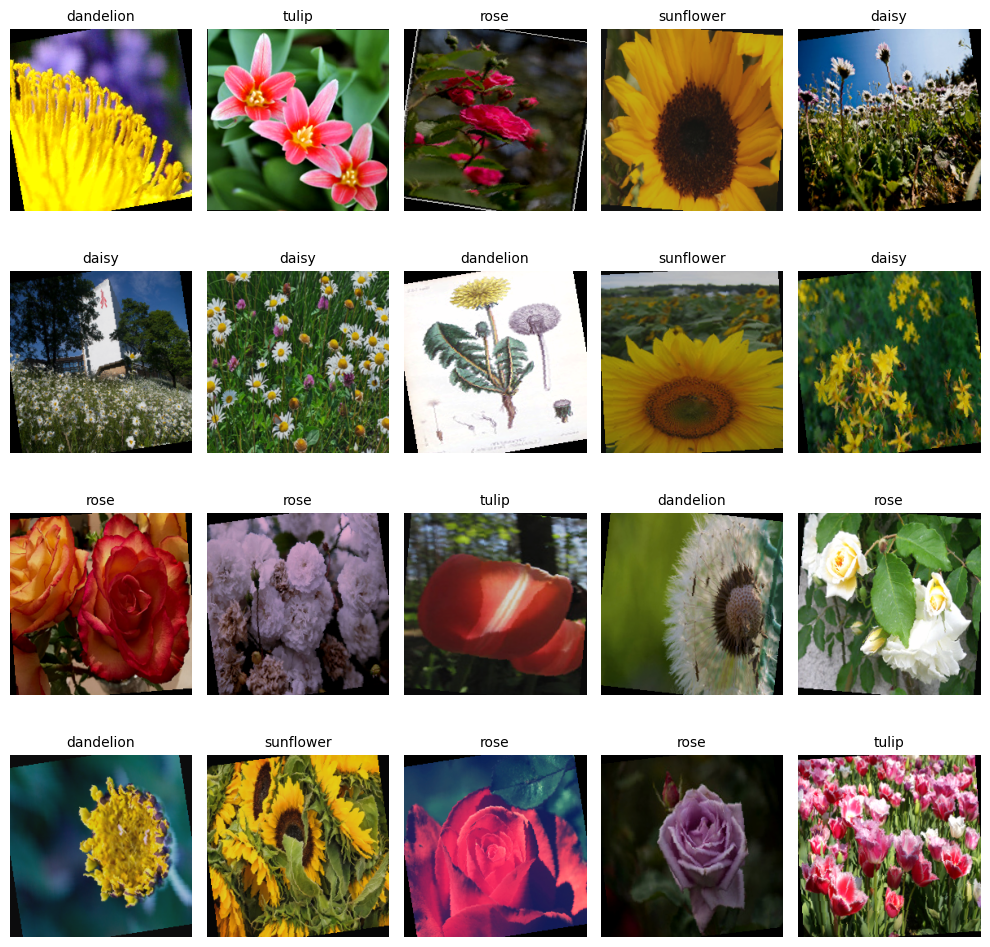

In [204]:
show_dataset_grid(train_dataset)

In [50]:
# Check one image size
img, label = train_dataset[0]
print('Image tensor shape:', img.shape)  # e.g. torch.Size([3, 224, 224])
NUM_CLASSES = 5

Image tensor shape: torch.Size([3, 224, 224])


## 3. Building and training the model

In [51]:
# Checking GPU availability
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


### CNN Architecture:

1. **Convolutional Layers (Conv2D)**  
   - Apply filters (kernels) that slide over the image  
   - Detect local patterns → edges → textures → shapes → objects  
   - Padding added to preserve spatial dimensions and retain more information for deeper layers.

2. **Pooling Layers**  
   - Reduce spatial dimensions (downsampling)  
   - Lower computation cost and add translation invariance  
   - **Adaptive Pooling** reduces feature maps to a fixed size (e.g., 7×7), making fully connected layers more memory-efficient and enabling variable input sizes

3. **Fully Connected Layers**  
   - Flatten feature maps into vectors  
   - Classify into output categories (e.g., flower species)  

4. **Activation Functions (ReLU)**  
   - Introduce non-linearity so the model can learn complex patterns  

5. **Regularization Layers**  
   - **Dropout**: randomly “drops” neurons during training → prevents over-reliance on specific features, improves robustness. Slows down training.
   - **Batch Normalization**: stabilizes training by normalizing activations → faster convergence.Speeds up training.

6. **Output Layer (Softmax / Log-Softmax)**
  - Converts final logits into probabilities across classes.
  - For classification tasks, ensures outputs sum to 1 (Softmax) or works with NLLLoss (Log-Softmax).

In [52]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(CustomCNN, self).__init__()

        # Convolutional layers with padding + BatchNorm
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)
        # Calculate the size after convolution and pooling to flatten correctly
        # Input image size: (224, 224)
        # With padding=1, convolutions preserve spatial dimensions
        # Each MaxPool2d layer halves the width/height:
        #   224 -> 112 -> 56 -> 28
        # AdaptiveAvgPool2d then reduces to fixed size (7x7),
        # regardless of input dimensions
        # So feature map size after last pool: 128 channels, 7x7 spatial size

        # Adaptive pooling reduces feature map to fixed size (7x7)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        self.flatten_size = 128 * 7 * 7  # 6272 features

        # Fully connected layers with BatchNorm and Dropout
        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Conv Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool(x)

        # Conv Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool(x)

        # Conv Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool(x)

        # Adaptive pooling + flatten
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)

        # Fully connected layers
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1) # For classification with NLLLoss

### **Training Setup:**

1. **Loss Function**
- Standard for multi-class classification.
- Combines `LogSoftmax` and `NLLLoss` in one function.


2. **Optimizer**
- **Adam (lr=0.01, weight_decay=1e-5)**
- **Adam(Adaptive Moment Estimation)** - Combines the strengths of Momentum (smooths updates) and RMSProp (scales by past gradients).
- Adaptive per-parameter learning rates → faster convergence, works well for small datasets and unstable training.
- Considering size of the datset there is no point in using SGD.


- **Weight decay** (L2 regularization) penalizes large weights → reduces overfitting.
- Learning rate is slightly higher than default since BatchNorm makes training more stable
3. **Learning Rate Scheduler**
- **StepLR (step_size=5, gamma=0.1)**
- Reduces LR by factor of 10 every 10 epochs.
- Helps fine-tune training by using large LR early (faster learning) and small LR later (stable convergence).


4. **Early Stopping**
- Monitors **validation loss each** epoch.
- Patience = 5 → stop training if val_loss does not improve for 5 epochs.
- Prevents overfitting and saves compute time.


5. **Training Parameters**
- **Epochs** = 100 (upper bound; early stopping usually ends earlier).


In [53]:
# Training parameters
EPOCHS = 100 # with this size of dataset 30 is enough, but with early stopping it may be set up high
NUM_CLASSES = 5
LEARNING_RATE = 0.01 # higher because batch normalisation, without it .001 would be good
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomCNN(num_classes=NUM_CLASSES).to(DEVICE)

# 3. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
# Scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Early stopping
best_val_loss = float("inf")
counter = 0
patience = 5

summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
       BatchNorm2d-5         [-1, 64, 112, 112]             128
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
       BatchNorm2d-8          [-1, 128, 56, 56]             256
         MaxPool2d-9          [-1, 128, 28, 28]               0
AdaptiveAvgPool2d-10            [-1, 128, 7, 7]               0
           Linear-11                  [-1, 128]         802,944
      BatchNorm1d-12                  [-1, 128]             256
          Dropout-13                  [-1, 128]               0
           Linear-14                   

### **Training Loop**

 1. Epoch Loop
- Iterate for a fixed number of epochs (`EPOCHS`).
 2. Training Phase
- Set model to **training mode** (`model.train()`).
- For each batch from `train_loader`:
  - Move data to GPU/CPU (`DEVICE`).
  - Zero gradients (`optimizer.zero_grad()`).
  - Forward pass → compute predictions (`model(inputs)`).
  - Compute loss (`criterion(outputs, labels)`).
  - Backward pass (`loss.backward()`).
  - Optimizer step (`optimizer.step()`).
  - Track running **loss** and **accuracy**.

 3. Training Metrics
- Compute **epoch loss** and **accuracy** from accumulated stats.
- Print progress (epoch number, loss, accuracy, learning rate).

 4. Validation Phase
- Switch to **evaluation mode** (`model.eval()`).
- Disable gradient tracking (`torch.no_grad()`).
- Run validation loop over `val_loader`.
- Compute **validation loss** and **accuracy**.
- Print validation results.
5. Early Stopping
- Save the model if validation loss improves (`best_model.pth`).
- If no improvement for `patience` epochs → **stop training early**.

 6. Learning Rate Scheduler
- Step the scheduler once per epoch (`scheduler.step()`).




In [54]:
# Trainining loop
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_loss /= val_total
    val_acc = val_correct / val_total
    print(f"Validation - Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

    # Step the scheduler once per epoch
    scheduler.step()

Epoch 1/100 - Loss: 1.2914, Accuracy: 0.4579, LR: 0.010000
Validation - Loss: 1.1483, Accuracy: 0.5370
Epoch 2/100 - Loss: 1.1554, Accuracy: 0.5320, LR: 0.010000
Validation - Loss: 1.0827, Accuracy: 0.5694
Epoch 3/100 - Loss: 1.0814, Accuracy: 0.5668, LR: 0.010000
Validation - Loss: 1.0386, Accuracy: 0.5856
Epoch 4/100 - Loss: 1.0434, Accuracy: 0.5980, LR: 0.010000
Validation - Loss: 0.9232, Accuracy: 0.6435
Epoch 5/100 - Loss: 1.0090, Accuracy: 0.6090, LR: 0.010000
Validation - Loss: 0.9184, Accuracy: 0.6458
Epoch 6/100 - Loss: 1.0006, Accuracy: 0.6137, LR: 0.010000
Validation - Loss: 0.9770, Accuracy: 0.6250
Epoch 7/100 - Loss: 0.9735, Accuracy: 0.6273, LR: 0.010000
Validation - Loss: 0.8394, Accuracy: 0.6551
Epoch 8/100 - Loss: 0.9132, Accuracy: 0.6490, LR: 0.010000
Validation - Loss: 0.8416, Accuracy: 0.6829
Epoch 9/100 - Loss: 0.8756, Accuracy: 0.6620, LR: 0.010000
Validation - Loss: 0.8784, Accuracy: 0.6528
Epoch 10/100 - Loss: 0.8630, Accuracy: 0.6696, LR: 0.010000
Validation - 

## 4. Inference

### Evaluation

Test Loss: 0.5517, Test Accuracy: 0.8056
              precision    recall  f1-score   support

       daisy       0.85      0.79      0.82        76
   dandelion       0.79      0.91      0.85       105
        rose       0.82      0.70      0.75        79
   sunflower       0.79      0.77      0.78        73
       tulip       0.80      0.82      0.81        99

    accuracy                           0.81       432
   macro avg       0.81      0.80      0.80       432
weighted avg       0.81      0.81      0.80       432



<Axes: >

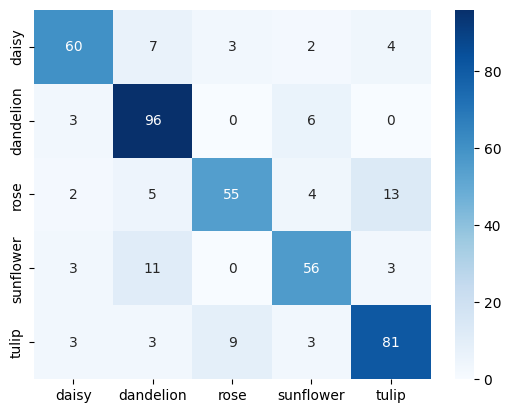

In [55]:
# Final evaluation
model.eval()
test_loss = 0
correct = 0
total = 0

y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * inputs.size(0)   # multiply by batch size
        preds = torch.argmax(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # store for metrics
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Final test metrics
test_loss /= total
test_acc = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Classification report
target_names = label_encoder.classes_   # all original class names
print(classification_report(y_true, y_pred, target_names=target_names))


# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)

### **Final Evaluation Summary**

### Overall Test Performance
- **Loss:** 0.5517  
- **Accuracy:** 0.8056 (~81%)

1. **Loss**
- **Cross-entropy loss = 0.5517** → predictions are fairly confident.  
- A loss below 1.0 indicates the model usually assigns higher probability to the correct class than to incorrect ones.  
- Further lowering loss (e.g., <0.3) would imply even sharper probability distributions.  

2. **Accuracy**
- **Accuracy = 81%** → about 4 out of 5 flowers are classified correctly.  
- This shows the model learned meaningful visual representations well beyond random guessing (20% for 5 classes).  
- Accuracy alone hides class-level differences → so we also check **precision, recall, and F1**.  

---

### Class-wise Metrics

| Class      | Precision | Recall | F1-score | Support |
|------------|-----------|--------|----------|---------|
| Daisy      | 0.85      | 0.79   | 0.82     | 76      |
| Dandelion  | 0.79      | 0.91   | 0.85     | 105     |
| Rose       | 0.82      | 0.70   | 0.75     | 79      |
| Sunflower  | 0.79      | 0.77   | 0.78     | 73      |
| Tulip      | 0.80      | 0.82   | 0.81     | 99      |

- **Daisies (F1 = 0.82)**: High precision, but recall a bit lower (some daisies missed).  
- **Dandelions (F1 = 0.85)**: Very strong recall (0.91) → most dandelions are detected.  
- **Roses (F1 = 0.75)**: Weakest recall (0.70) → many roses are misclassified.  
- **Sunflowers (F1 = 0.78)**: Balanced performance, but not standout.  
- **Tulips (F1 = 0.81)**: Consistent with both precision and recall around 0.80.  

---

### Macro vs Weighted Averages
- **Macro Avg (F1 = 0.80)** → treats all classes equally, showing performance is balanced across classes.  
- **Weighted Avg (F1 = 0.80)** → similar values indicate dataset is fairly balanced, with no single dominant class skewing results.  

---

### Confusion Matrix Insights

1. **Roses remain the hardest class**  
   - Only 70% recall (55/79 correct).  
   - Misclassifications mainly into **Tulips** and **Dandelions** (similar colors/structures).  

2. **Dandelions are easiest**  
   - 91% recall (96/105 correct).  
   - Very few misclassifications, confirming they are visually distinct.  

3. **Daisies**  
   - 79% recall (60/76 correct).  
   - Errors spread across other classes, especially **Dandelions** and **Roses**.  

4. **Sunflowers**  
   - 77% recall (56/73 correct).  
   - Confusions mostly with **Dandelions** (yellow color overlap).  

5. **Tulips**  
   - 82% recall (81/99 correct).  
   - Misclassified as **Roses** fairly often, reflecting visual similarity.  

---

### **Takeaways**
- **Accuracy (81%)** confirms good generalization across 5 flower classes.  
- **Loss (0.5517)** suggests reasonably confident predictions.  
- The main bottleneck is **roses**, which overlap visually with tulips and dandelions.  
- **Dandelions are the easiest class**, nearly always detected correctly.  
- The model does well on visually distinct classes, but struggles where flowers share **color and petal structure similarities**.  



### Saving model and making sample predictions

In [58]:
# Saving model
torch.save(model.state_dict(), 'model.pth')  # only weights

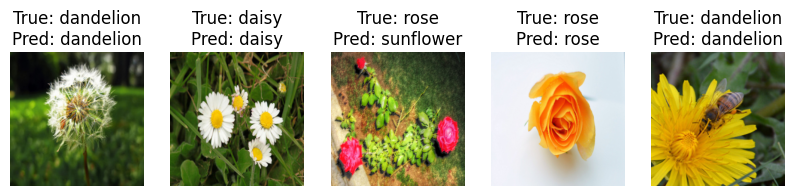

In [75]:
# Load model
model.load_state_dict(torch.load('model.pth'))
model.eval()

num_examples = 5

fig, axes = plt.subplots(1, num_examples, figsize=(10, 5))

for i in range(num_examples):
    image, label = test_dataset[i]
    image_input = image.unsqueeze(0).to(DEVICE)

    # Predict
    with torch.no_grad():
        output = model(image_input)
        pred = torch.argmax(output, dim=1).item()

    # Convert image for plotting
    img = image.permute(1, 2, 0).cpu().numpy()  # C,H,W -> H,W,C
    # Undo normalization for display
    img = img * std + mean   # just use std and mean as arrays
    img = img.clip(0, 1)

    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f"True: {label_encoder.inverse_transform([label])[0]}\nPred: {label_encoder.inverse_transform([pred])[0]}")

plt.show()

As previous metrics suggested, we can see rose being misclassified

### Ways to improve performance:
1. **Experimenting with training setup**
- Such as switching from Adam to SGD later, with CosineAnnealingLR for smoother convergence
- or with weight initialization
2. **Class Rebalancing**
- Oversampling roses
3. **Tuning hyperparameters**
- May help a little, data-oriented methods and more complex models are better for improving performance
4. **Transfer Learning** - which will be the subject of next notebook

## Error Analysis

In [124]:
# Collecting misclassified samples
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(DEVICE))
        preds = outputs.argmax(1).cpu()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.numpy())

In [125]:
# 2. Identifying misclassified indices
y_true = np.array(y_true)
y_pred = np.array(y_pred)
errors = np.where(y_true != y_pred)[0]
percent =  100 * (len(errors))/(len(y_true))
print(f"Total misclassified: {len(errors)} / {len(y_true)}")
print(f"Total misclassified percent : {percent:.2f} %")

Total misclassified: 84 / 432
Total misclassified percent : 19.44 %


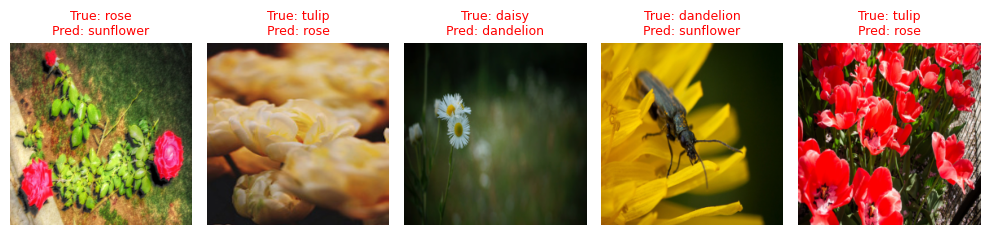

In [119]:
# Visualizing misclassified images

num_examples = 5

# Find misclassified indices
errors = [i for i, (yt, yp) in enumerate(zip(y_true, y_pred)) if yt != yp]

fig, axes = plt.subplots(1, num_examples, figsize=(10, 5))

for ax, idx in zip(axes, errors[:num_examples]):
    image, label = test_dataset[idx]
    image_input = image.unsqueeze(0).to(DEVICE)

    # Predict again (or just use y_pred[idx])
    with torch.no_grad():
        output = model(image_input)
        pred = torch.argmax(output, dim=1).item()

    # Undo normalization for display
    img = image.permute(1, 2, 0).cpu().numpy()   # (H, W, C)
    img = img * std + mean                       # unnormalize
    img = img.clip(0, 1)

    ax.imshow(img)
    ax.axis('off')
    ax.set_title(
        f"True: {label_encoder.inverse_transform([label])[0]}\n"
        f"Pred: {label_encoder.inverse_transform([pred])[0]}",
        color="red", fontsize=9
    )

plt.tight_layout()
plt.show()

Plot suggests that wrong predictions may be the result of color similarity

In [144]:
# Class-Specific errors
# Collect (true, pred) pairs for misclassified samples
confusions = [(y_true[i], y_pred[i]) for i in errors]

# Count occurrences of each confusion pair
confusion_counts = Counter(confusions)

# Convert to DataFrame with readable class names
df_conf = pd.DataFrame([
    {
        "True": label_encoder.inverse_transform([t])[0],
        "Pred": label_encoder.inverse_transform([p])[0],
        "Count": c
    }
    for (t, p), c in confusion_counts.items()
])

# Sort by most frequent confusions
df_conf = df_conf.sort_values("Count", ascending=False).reset_index(drop=True)

df_conf

True       Pred  Count
0        rose      tulip     13
1   sunflower  dandelion     11
2       tulip       rose      9
3       daisy  dandelion      7
4   dandelion  sunflower      6
5        rose  dandelion      5
6        rose  sunflower      4
7       daisy      tulip      4
8       daisy       rose      3
9       tulip  dandelion      3
10  dandelion      daisy      3
11      tulip  sunflower      3
12      tulip      daisy      3
13  sunflower      tulip      3
14  sunflower      daisy      3
15       rose      daisy      2
16      daisy  sunflower      2

### Class-Specific errors
**Most common errors:**

**Roses ↔ Tulips (13 vs 9 errors)**

- Strongest confusion pair. Likely due to similar petal shapes and overlapping red/pink color tones.

- Suggests model struggles to separate fine-grained floral structure.

**Sunflowers ↔ Dandelions (11 vs 6 errors)**
- Both are yellow flowers with dense petals, leading to high mutual confusion.

- Indicates color dominance in feature learning rather than global shape.

**Daisies ↔ Dandelions (7 vs 3 errors)**

- White-petaled daisies and yellow-centered dandelions overlap visually in petal spread and size.

**Secondary confusions (3–4 errors each)**
- Roses misclassified as dandelions/sunflowers → red/pink flowers sometimes mistaken for yellow, showing color invariance is weak.

- Tulips misclassified as multiple classes → tulips’ diverse colors/patterns make them less distinct.

- Sunflowers confused with tulips/daisies (3 each) → highlights background similarity or scale sensitivity.
----
**Most errors occur between visually similar pairs, so more aggressive data augmentation may help improve the model**

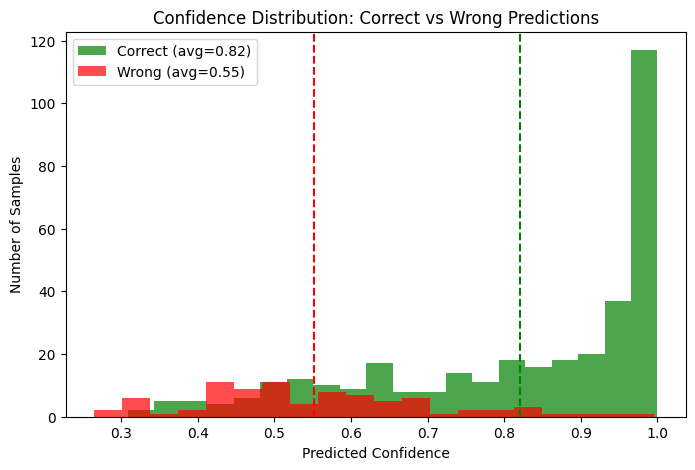

Avg confidence (correct): 0.8209332
Avg confidence (wrong): 0.55197173


In [98]:
all_probs = []
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(DEVICE))
        probs = F.softmax(outputs, dim=1).cpu()
        preds = probs.argmax(1)

        # save top-1 probability, predicted class, and true label
        all_probs.extend(probs.max(1).values.numpy())
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

# convert to arrays
all_probs = np.array(all_probs)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# correctness mask
correct_mask = all_preds == all_labels
wrong_mask   = ~correct_mask

# confidences split
conf_correct = all_probs[correct_mask]
conf_wrong   = all_probs[wrong_mask]

# plot histogram
plt.figure(figsize=(8,5))
plt.hist(conf_correct, bins=20, alpha=0.7, label=f"Correct (avg={conf_correct.mean():.2f})", color="green")
plt.hist(conf_wrong, bins=20, alpha=0.7, label=f"Wrong (avg={conf_wrong.mean():.2f})", color="red")
plt.axvline(conf_correct.mean(), color="green", linestyle="--")
plt.axvline(conf_wrong.mean(), color="red", linestyle="--")
plt.xlabel("Predicted Confidence")
plt.ylabel("Number of Samples")
plt.title("Confidence Distribution: Correct vs Wrong Predictions")
plt.legend()
plt.show()

print("Avg confidence (correct):", conf_correct.mean())
print("Avg confidence (wrong):", conf_wrong.mean())


### Confidence Analysis
**Avg confidence (correct) = 0.82**
- When the model predicts correctly, it assigns on average 82% probability to its chosen class.

- This shows the model is reasonably confident when it’s right.

**Avg confidence (wrong) = 0.55**
- When the model is wrong, it still assigns about 55% probability to its (incorrect) prediction.

- This means the model often makes confident mistakes, instead of being uncertain and spreading probability across classes.
---
- The gap (0.82 vs 0.55) shows the model does distinguish between “easy” and “hard” examples, but not perfectly.

- Ideally, confidence should be high on correct predictions and much lower on wrong ones.

- The fact that it’s still >0.5 on errors suggests the model is overconfident — calibration techniques (e.g., temperature scaling, Platt scaling) could help make probabilities more reliable.